#### 📚 Book Recommendation System  

##### 🎯 Project Goal
The goal of this project is to build a **Recommendation System** that suggests books to users using two main techniques:  

- **Content-Based Filtering (CBF)** → Recommends books based on book features (e.g., tags, authors, metadata).  
- **Collaborative Filtering (CF)** → Recommends books based on user–item interactions (ratings).  

---

##### 🗂️ Dataset Overview
We will work with multiple CSV files:  
- `books.csv` → Metadata about books (titles, authors, ratings, etc.).  
- `ratings.csv` → User ratings for books.  
- `to_read.csv` → Books users marked "to read".  
- `book_tags.csv` + `tags.csv` → Tags applied to books (useful for content features).  

---




![Line Chart](line.png)


In [156]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import missingno as msno

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error,precision_score

from rapidfuzz import process, fuzz #for string Matching Like fuzzy Wuzzy

from math import sqrt

from scipy.sparse import coo_matrix

import warnings
warnings.filterwarnings('ignore')

### Loading DataSet [Rating,To read, Books, Tags, Book Tags]

In [157]:
df_rating = pd.read_csv('ratings.csv')
df_toread = pd.read_csv('to_read.csv')
df_books = pd.read_csv('books.csv')
df_tags = pd.read_csv('tags.csv')
df_booktags = pd.read_csv('book_tags.csv')

In [158]:
print(f'df Shapes: \n Rating: {df_rating.shape[0]} Rows, {df_rating.shape[1]} Columns \n To Read: {df_toread.shape[0]} Rows, {df_toread.shape[1]} Columns \n Books: {df_books.shape[0]} Rows, {df_books.shape[1]} Columns \n Tags: {df_tags.shape[0]} Rows, {df_tags.shape[1]} Columns \n Book Tags: {df_booktags.shape[0]} Rows, {df_booktags.shape[1]} Columns')

df Shapes: 
 Rating: 5976479 Rows, 3 Columns 
 To Read: 912705 Rows, 2 Columns 
 Books: 10000 Rows, 23 Columns 
 Tags: 34252 Rows, 2 Columns 
 Book Tags: 999912 Rows, 3 Columns


In [159]:
pd.set_option('display.max_columns', None)
print("Sample from:\ndf_books:")
display(df_books.sample())
print("df_rating:")
display(df_rating.sample())
print("\ndf_toread:")
display(df_toread.sample(1))
print("\ndf_tags:")
display(df_tags.sample(1))
print("\ndf_booktags:")
display(df_booktags.sample())

Sample from:
df_books:


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
809,810,1087204,1087204,2192688,17,1591169151,9.781591e+12,Bisco Hatori,2003.0,桜蘭高校ホスト部 1,"Ouran High School Host Club, Vol. 1 (Ouran Hig...",eng,4.36,113881,114117,949,2338,3593,13572,26298,68316,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


df_rating:


,user_id,book_id,rating
1352507,19655,367,3



df_toread:


,user_id,book_id
115568,18799,625



df_tags:


,tag_id,tag_name
23796,23796,pnr



df_booktags:


,goodreads_book_id,tag_id,count
755895,9593911,30574,1896


#### Drop Unnecessary Columns in Books DataFrame

In [160]:
df_books.drop(columns=["isbn","isbn13", "small_image_url"],inplace=True)

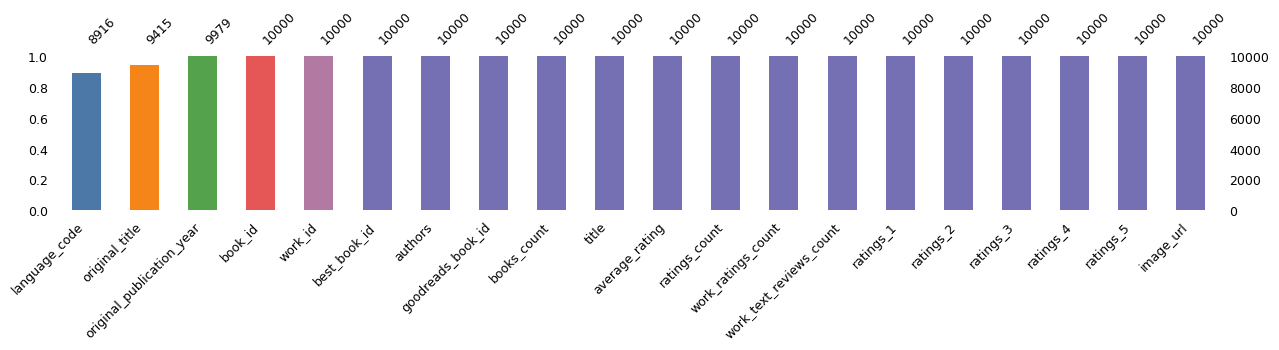

In [161]:
missingcolors_hex = ["#4C78A8", "#F58518", "#54A24B", "#E45756", "#B279A2", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3"]

msno.bar(df_books,figsize=(15, 2),color=missingcolors_hex,fontsize=9,sort='ascending')
plt.show()

In [162]:
print(f"Original title Contains {df_books['original_title'].isnull().sum()} Missing Values")
display(df_books.loc[df_books['original_title'].isnull()].head(5)[['original_title','title']])


Original title Contains 585 Missing Values


,original_title,title
74,NaN,"Bridget Jones's Diary (Bridget Jones, #1)"
142,NaN,All the Light We Cannot See
209,NaN,"Vampire Academy (Vampire Academy, #1)"
214,NaN,Ready Player One
256,NaN,Alice in Wonderland


### Fill Missing Values in orignial title

In [163]:
df_books['original_title'] = df_books['original_title'].fillna(df_books['title'])
df_books['original_title'].isnull().sum()

np.int64(0)

#### 53424 Users with Around 5.97 Million Books Ratings

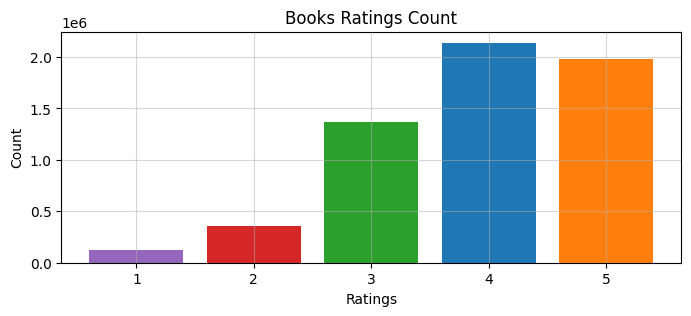

In [164]:
ratingcolors_hex=[ "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

plt.figure(figsize=(8,3))
plt.bar(df_rating['rating'].value_counts().index.tolist(), df_rating['rating'].value_counts().tolist(), color=ratingcolors_hex)
plt.title('Books Ratings Count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.grid(alpha=0.5)
plt.show()

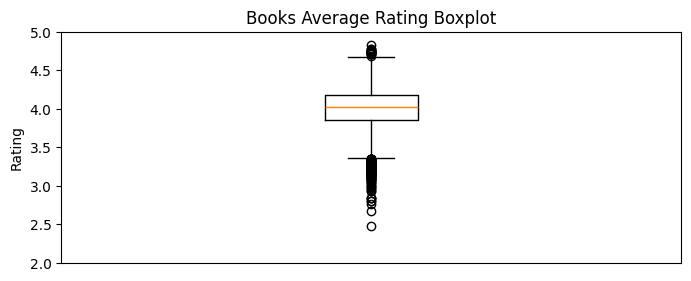

In [165]:
plt.figure(figsize=(8,3))

plt.title('Books Average Rating Boxplot')
plt.boxplot(df_books['average_rating'])
plt.ylabel('Rating')
plt.xticks([])
plt.yticks(np.arange(2,5.5,0.5))

plt.show()

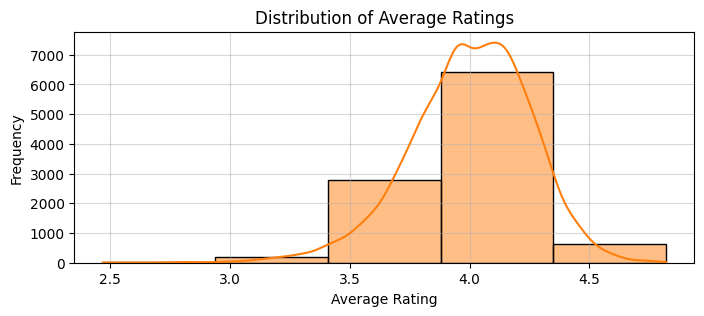

In [166]:
plt.figure(figsize=(8,3))

sns.histplot(df_books['average_rating'],bins=5, kde=True, color='#ff7f0e')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(alpha=0.5)
plt.show()

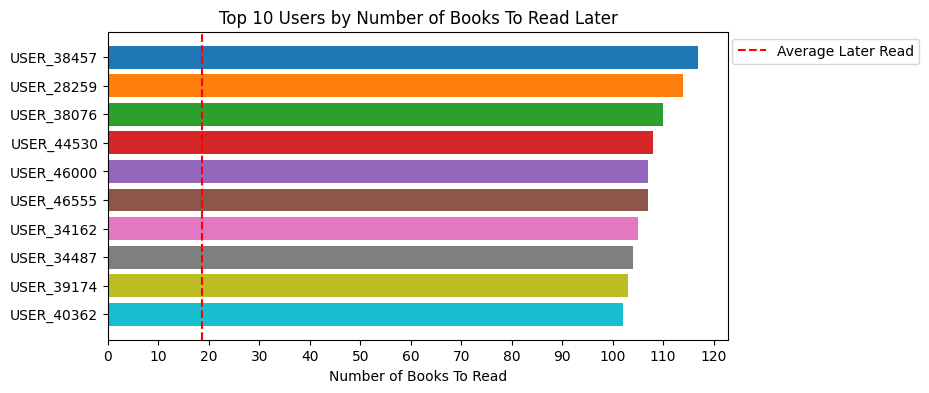

In [167]:
readcountforuser = df_toread.groupby('user_id').count()
toreadcolors_hex = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
]
TopTenUsersReadLater = readcountforuser['book_id'].sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))

plt.title('Top 10 Users by Number of Books To Read Later')
plt.barh('USER_'+TopTenUsersReadLater.index.astype(str),  TopTenUsersReadLater.values, color=toreadcolors_hex)
plt.xticks(np.arange(0,121,10))
plt.xlabel('Number of Books To Read')

plt.gca().invert_yaxis()  # optional: highest number at top
plt.axvline(readcountforuser['book_id'].mean(), color='red', linestyle='--', label='Average Later Read')
plt.legend(bbox_to_anchor=(1.32, 1),loc='upper right')

plt.show()


In [168]:
df_books['language_code'].value_counts().head(10).to_dict().items()

dict_items([('eng', 6341), ('en-US', 2070), ('en-GB', 257), ('ara', 64), ('en-CA', 58), ('fre', 25), ('ind', 21), ('spa', 20), ('ger', 13), ('jpn', 7)])

#### Around 97.9% of Books Language is English

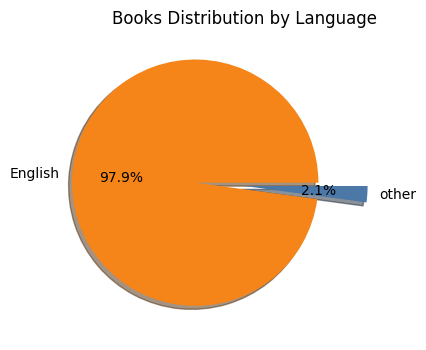

In [169]:
Languagescount=[8726,190]
LanguagesLabels=['English','other']
languagescolors_hex = ["#F58518", "#4C78A8"]

plt.figure(figsize=(8,4))
plt.title("Books Distribution by Language")
plt.pie(Languagescount,labels=LanguagesLabels,autopct='%1.1f%%', colors=languagescolors_hex, explode=(0.4, 0), shadow=True)

plt.show()

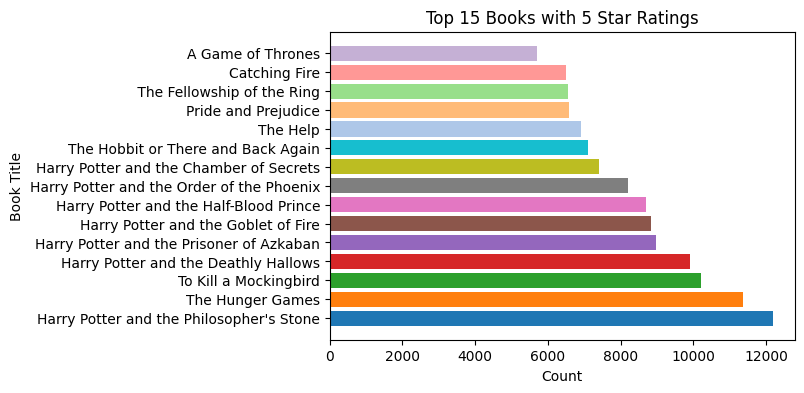

In [170]:
Top_books_Ratedvalues = pd.merge(df_rating.loc[df_rating['rating']==5]['book_id'].value_counts().head(15), df_books[['book_id', 'original_title','authors']],how="inner", on="book_id")

colors_hex = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5"
]
plt.figure(figsize=(6,4)) 
plt.barh(Top_books_Ratedvalues['original_title'], Top_books_Ratedvalues['count'], color=colors_hex)
plt.title('Top 15 Books with 5 Star Ratings')
plt.xlabel('Count')
plt.ylabel('Book Title')
plt.show()

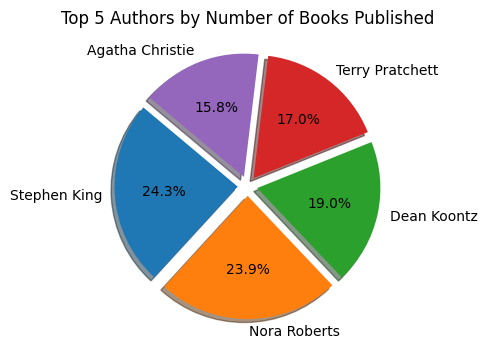

In [171]:
authorsbooks=df_books['authors'].value_counts().head()
authorsbooks_colors_hex = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
plt.figure(figsize=(10,4))
plt.title('Top 5 Authors by Number of Books Published')
explode=[0.08, 0.08, 0.08, 0.08, 0.08]
plt.pie(authorsbooks, labels=authorsbooks.index, autopct='%1.1f%%', colors=authorsbooks_colors_hex, explode=explode, shadow=True,startangle=140)

plt.show()

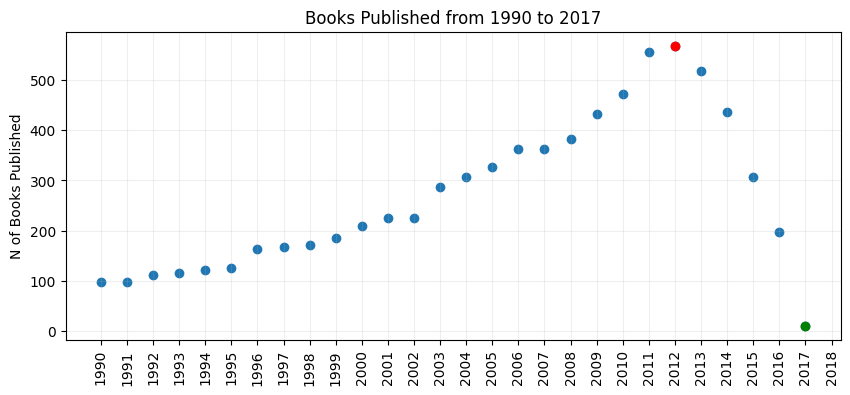

In [172]:
yearsdict=df_books.loc[df_books['original_publication_year']>=1990][['original_title','authors','original_publication_year']]['original_publication_year'].value_counts().sort_index().to_dict()

plt.figure(figsize=(10,4))
plt.title('Books Published from 1990 to 2017')

plt.scatter(yearsdict.keys(), yearsdict.values(), color='#1f77b4')
plt.xticks(np.arange(1990,2019,1),rotation=90)
plt.ylabel('N of Books Published')
plt.grid(alpha=0.2)

plt.plot(2012, 568, 'o',color='red')
plt.plot(2017, 11, 'o',color='green')

plt.show()

In [173]:
display(df_tags.sample())
display(df_booktags.sample())

,tag_id,tag_name
4355,4355,best-of-2014


,goodreads_book_id,tag_id,count
928907,18867685,26816,5


In [174]:
df_fulltags=pd.merge(df_booktags,df_tags,how='inner',on='tag_id')
df_fulltags.head(5)

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,1,11305,37174,fantasy
2,1,11557,34173,favorites
3,1,8717,12986,currently-reading
4,1,33114,12716,young-adult


In [175]:
TopRepeatedTags=df_fulltags.groupby('tag_name').count().sort_values(by='count',ascending=False)['count'][:15].to_dict()

In [176]:
enumerate(TopRepeatedTags.items())

In [177]:
for i,(key,value) in enumerate(TopRepeatedTags.items()):
    print(key,value)

to-read 9983
favorites 9881
owned 9858
books-i-own 9799
currently-reading 9776
library 9415
owned-books 9221
fiction 9097
to-buy 8692
kindle 8316
default 8239
ebook 8054
my-books 7561
audiobook 7242
ebooks 7203


In [178]:
uselesstags=df_fulltags['tag_name'].value_counts()
uselesstags.values[:41]

array([9983, 9881, 9858, 9799, 9776, 9415, 9221, 9097, 8692, 8316, 8239,
       8054, 7561, 7242, 7203, 7192, 7000, 6862, 6670, 6604, 6548, 6422,
       5665, 5514, 5287, 5239, 5080, 4941, 4940, 4902, 4818, 4775, 4616,
       4384, 4365, 4346, 4259, 4251, 4220, 4168, 4084])

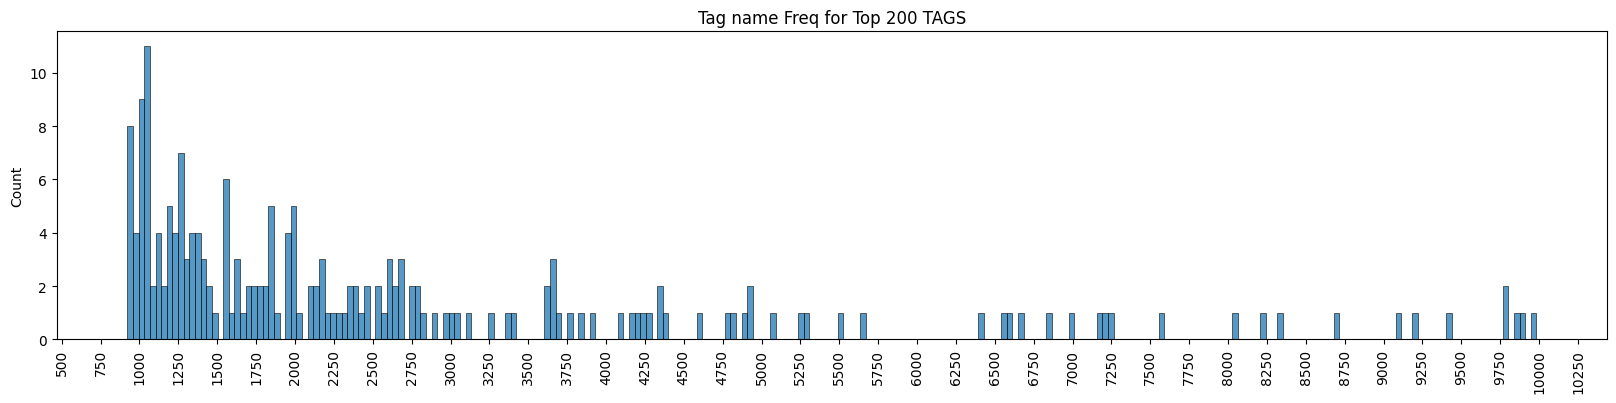

In [179]:
plt.figure(figsize=(20,4))

plt.title('Tag name Freq for Top 200 TAGS')
sns.histplot(uselesstags.values[:200],bins=250)
plt.xticks(np.arange(500,10500,250),rotation=90)

plt.show()

In [180]:
df_fulltags = df_fulltags[~df_fulltags['tag_name'].isin(uselesstags.index[:41])]

In [181]:
tags_aggregated = df_fulltags.groupby('goodreads_book_id')['tag_name'].apply(list).reset_index()

tags_aggregated.head(10)

,goodreads_book_id,tag_name
0,1,"[young-adult, harry-potter, ya, magic, childre..."
1,2,"[children, children-s, all-time-favorites, you..."
2,3,"[young-adult, harry-potter, ya, magic, childre..."
3,5,"[young-adult, harry-potter, ya, magic, childre..."
4,6,"[young-adult, harry-potter, ya, childrens, re-..."
5,8,"[harry-potter, young-adult, magic, ya, j-k-row..."
6,10,"[harry-potter, young-adult, magic, ya, childre..."
7,11,"[science-fiction, sci-fi, humor, classics, sci..."
8,13,"[science-fiction, sci-fi, humor, classics, sci..."
9,21,"[history, nonfiction, non-fiction, science, hu..."


In [182]:
df_books_with_tags = pd.merge(df_books.drop('image_url',axis=1), tags_aggregated, on='goodreads_book_id', how='left')

df_books_with_tags.head(1)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,tag_name
0,1,2767052,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,"[young-adult, dystopian, dystopia, ya, science..."


In [183]:
languageslist=df_books_with_tags['language_code'].value_counts().index.tolist()
languageslist

['eng',
 'en-US',
 'en-GB',
 'ara',
 'en-CA',
 'fre',
 'ind',
 'spa',
 'ger',
 'jpn',
 'per',
 'pol',
 'por',
 'en',
 'dan',
 'nor',
 'fil',
 'ita',
 'nl',
 'tur',
 'vie',
 'swe',
 'rum',
 'mul',
 'rus']

In [184]:
en=['eng','en-US','en-GB','en-CA']
ar=['ara']
rarelanguages=languageslist[5:]

In [185]:
def simplify_language(code):
    if code in en:
        return "eng"
    elif code in ar:
        return "ara"
    elif code in rarelanguages:
        return "rare"
    else:
        return "unknown"

In [186]:
df_books_with_tags["language_code"] = df_books_with_tags["language_code"].fillna("unknown")

In [187]:
df_books_with_tags["language_grouped"] = df_books_with_tags["language_code"].apply(simplify_language)

In [188]:
df_books_with_tags['full_title']=df_books_with_tags['original_title'].fillna(" ")+" "+df_books_with_tags['title'].fillna(" ")
df_books_with_tags['full_title']=df_books_with_tags['full_title'].str.lower()

In [189]:
author_freq = df_books_with_tags['authors'].value_counts().to_dict()
df_books_with_tags['author_freq'] = df_books_with_tags['authors'].map(author_freq)

In [190]:
df_books_with_tags.shape

(10000, 23)

In [191]:
df_books_with_tags.sample()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,tag_name,language_grouped,full_title,author_freq
1296,1297,10798416,10798416,15464655,59,Jennifer E. Smith,2012.0,The Statistical Probability of Love at First S...,The Statistical Probability of Love at First S...,eng,3.8,89356,95856,9595,2569,7379,25452,32106,28350,"[young-adult, ya, realistic-fiction, chick-lit...",eng,the statistical probability of love at first s...,3


In [192]:
df_books_with_tags.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'tag_name',
       'language_grouped', 'full_title', 'author_freq'],
      dtype='object')

In [193]:
df_books_with_tags = df_books_with_tags.drop(['book_id',  'best_book_id', 'work_id','books_count','original_publication_year',
                                              'original_title', 'title','authors','language_code','ratings_count', 'work_ratings_count',
                                              'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3',
                                              'ratings_4', 'ratings_5'], axis=1)

In [194]:
#'goodreads_book_id'

In [195]:
df_books_with_tags.columns

Index(['goodreads_book_id', 'average_rating', 'tag_name', 'language_grouped',
       'full_title', 'author_freq'],
      dtype='object')

In [196]:
df_books_with_tags = pd.get_dummies(df_books_with_tags, columns=['language_grouped'], drop_first=True, dtype=float)

In [197]:
df_books_with_tags.sample()

,goodreads_book_id,average_rating,tag_name,full_title,author_freq,language_grouped_eng,language_grouped_rare,language_grouped_unknown
8915,765427,3.55,"[poetry, classics, literature, classic, britis...",the faerie queene the faerie queene,1,1.0,0.0,0.0


In [198]:
df_books_with_tags['average_rating'].describe()

count    10000.000000
mean         4.002191
std          0.254427
min          2.470000
25%          3.850000
50%          4.020000
75%          4.180000
max          4.820000
Name: average_rating, dtype: float64

In [199]:
scaler=StandardScaler()
df_books_with_tags['average_rating_scaled']=scaler.fit_transform(df_books_with_tags[['average_rating']])
df_books_with_tags['author_freq']=scaler.fit_transform(df_books_with_tags[['author_freq']])

In [200]:
df_books_with_tags.head()

,goodreads_book_id,average_rating,tag_name,full_title,author_freq,language_grouped_eng,language_grouped_rare,language_grouped_unknown,average_rating_scaled
0,2767052,4.34,"[young-adult, dystopian, dystopia, ya, science...",the hunger games the hunger games (the hunger ...,0.138378,1.0,0.0,0.0,1.327789
1,3,4.44,"[young-adult, harry-potter, ya, magic, childre...",harry potter and the philosopher's stone harry...,0.040901,1.0,0.0,0.0,1.720847
2,41865,3.57,"[young-adult, vampires, ya, paranormal, vampir...","twilight twilight (twilight, #1)",0.333331,1.0,0.0,0.0,-1.698765
3,2657,4.25,"[classics, classic, historical-fiction, school...",to kill a mockingbird to kill a mockingbird,-0.543959,1.0,0.0,0.0,0.974035
4,4671,3.89,"[classics, classic, literature, school, histor...",the great gatsby the great gatsby,-0.251529,1.0,0.0,0.0,-0.440977


In [201]:
df_books_with_tags["tag_name"] = df_books_with_tags["tag_name"].apply(lambda x: " ".join(x))

In [202]:
df_books_with_tags.loc[0]

goodreads_book_id                                                     2767052
average_rating                                                           4.34
tag_name                    young-adult dystopian dystopia ya science-fict...
full_title                  the hunger games the hunger games (the hunger ...
author_freq                                                          0.138378
language_grouped_eng                                                      1.0
language_grouped_rare                                                     0.0
language_grouped_unknown                                                  0.0
average_rating_scaled                                                1.327789
Name: 0, dtype: object

In [203]:
df_books_with_tags['book_title_tag']=df_books_with_tags['full_title']+" "+df_books_with_tags['tag_name']

In [204]:
df_books_with_tags.drop(['tag_name'],axis=1,inplace=True)

In [205]:
# df_books_with_tags.drop(['full_title','tag_name'],axis=1,inplace=True)

In [206]:
df_books_with_tags['book_title_tag'].loc[0]

'the hunger games the hunger games (the hunger games, #1) young-adult dystopian dystopia ya science-fiction sci-fi adventure hunger-games teen read-in-2012 post-apocalyptic the-hunger-games favorite-books action suzanne-collins re-read all-time-favorites ya-fiction survival sci-fi-fantasy favorite scifi 5-stars read-in-2011 young-adult-fiction thriller my-favorites read-2012 futuristic fantasy-sci-fi suspense shelfari-favorites faves reread read-in-2010 favorite-series teen-fiction ya-lit ya-books finished action-adventure love love-triangle favs loved distopia coming-of-age dystopian-fiction distopian borrowed english read-more-than-once favourite read-2011 favourite-books scifi-fantasy ya-fantasy future trilogy dystopias reviewed ya-dystopian speculative-fiction 2012-reads finished-series sf completed-series drama 5-star'

In [207]:
df_books_with_tags.columns

Index(['goodreads_book_id', 'average_rating', 'full_title', 'author_freq',
       'language_grouped_eng', 'language_grouped_rare',
       'language_grouped_unknown', 'average_rating_scaled', 'book_title_tag'],
      dtype='object')

In [208]:
df_books_with_tags.shape

(10000, 9)

In [209]:
# df_books_with_tags = df_books_with_tags.iloc[:, [6, 0, 5,1,2,3,4]] 

In [210]:
df_books_with_tags.loc[0]

goodreads_book_id                                                     2767052
average_rating                                                           4.34
full_title                  the hunger games the hunger games (the hunger ...
author_freq                                                          0.138378
language_grouped_eng                                                      1.0
language_grouped_rare                                                     0.0
language_grouped_unknown                                                  0.0
average_rating_scaled                                                1.327789
book_title_tag              the hunger games the hunger games (the hunger ...
Name: 0, dtype: object

In [211]:
df_books_with_tags['book_title_tag'].loc[0]

'the hunger games the hunger games (the hunger games, #1) young-adult dystopian dystopia ya science-fiction sci-fi adventure hunger-games teen read-in-2012 post-apocalyptic the-hunger-games favorite-books action suzanne-collins re-read all-time-favorites ya-fiction survival sci-fi-fantasy favorite scifi 5-stars read-in-2011 young-adult-fiction thriller my-favorites read-2012 futuristic fantasy-sci-fi suspense shelfari-favorites faves reread read-in-2010 favorite-series teen-fiction ya-lit ya-books finished action-adventure love love-triangle favs loved distopia coming-of-age dystopian-fiction distopian borrowed english read-more-than-once favourite read-2011 favourite-books scifi-fantasy ya-fantasy future trilogy dystopias reviewed ya-dystopian speculative-fiction 2012-reads finished-series sf completed-series drama 5-star'

#### re to remove useless regex in the "book_title_tag"

In [212]:
import re

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"[^\w\s]", " ", text)  
    return text.lower()

df_books_with_tags["book_title_tag"] = df_books_with_tags["book_title_tag"].apply(clean_text)

In [213]:
df_books_with_tags['book_title_tag'].loc[0]

'the hunger games the hunger games  the hunger games   1  young adult dystopian dystopia ya science fiction sci fi adventure hunger games teen read in 2012 post apocalyptic the hunger games favorite books action suzanne collins re read all time favorites ya fiction survival sci fi fantasy favorite scifi 5 stars read in 2011 young adult fiction thriller my favorites read 2012 futuristic fantasy sci fi suspense shelfari favorites faves reread read in 2010 favorite series teen fiction ya lit ya books finished action adventure love love triangle favs loved distopia coming of age dystopian fiction distopian borrowed english read more than once favourite read 2011 favourite books scifi fantasy ya fantasy future trilogy dystopias reviewed ya dystopian speculative fiction 2012 reads finished series sf completed series drama 5 star'

#### Now "book_title_tag" feature is ready for TF-IDF

In [214]:
vectorizer = TfidfVectorizer(stop_words='english',min_df=2)
BOOKS_tfidf=vectorizer.fit_transform(df_books_with_tags['book_title_tag'])

In [215]:
print(f"Books TF-IDF Shape is {BOOKS_tfidf.shape} With 628,589 Non Zero Values of {BOOKS_tfidf.shape[0]}*{BOOKS_tfidf.shape[1]}, Length of Stop Words Removed from Vectors {len(vectorizer.get_stop_words())} ")

Books TF-IDF Shape is (10000, 11193) With 628,589 Non Zero Values of 10000*11193, Length of Stop Words Removed from Vectors 318 


In [216]:
vectorizer.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

#### Due to Huge Sparse Matrix After Applying TD-IDF and Non zeroes values is about 0.57%, So Use TruncSVD to redcue dimensions 

In [217]:
n_components = 150

svd = TruncatedSVD(n_components=n_components, random_state=42)
Books_SVD = svd.fit_transform(BOOKS_tfidf)

In [218]:
print(f"Before TruncSVD Vectors length was {BOOKS_tfidf.shape[1]}, After TruncSVD {Books_SVD.shape[1]}")


Before TruncSVD Vectors length was 11193, After TruncSVD 150


#### Combination of "BookSVD" Matrix and "Books_numerical_features" Matrix

In [219]:
Books_numerical_features = df_books_with_tags[['average_rating_scaled', 'author_freq', 'language_grouped_eng', 'language_grouped_rare', 'language_grouped_unknown']].values

In [220]:
Books_numerical_features[:5,:]

array([[ 1.32778854,  0.138378  ,  1.        ,  0.        ,  0.        ],
       [ 1.72084749,  0.04090124,  1.        ,  0.        ,  0.        ],
       [-1.69876544,  0.3333315 ,  1.        ,  0.        ,  0.        ],
       [ 0.97403547, -0.54395926,  1.        ,  0.        ,  0.        ],
       [-0.44097678, -0.25152901,  1.        ,  0.        ,  0.        ]])

In [221]:
Books_Matrix = np.hstack((Books_SVD, Books_numerical_features))
Books_Matrix.shape

(10000, 155)

- **Content-Based Filtering (CBF)** → Recommends books based on book features

In [222]:
Books_cosine_sim_matrix = cosine_similarity(Books_Matrix, Books_Matrix)
print(Books_cosine_sim_matrix.shape)

(10000, 10000)


In [223]:
Books_cosine_sim_matrix[:5,:5]

array([[ 1.        ,  0.89014332, -0.25333625,  0.76970826,  0.1953498 ],
       [ 0.89014332,  1.        , -0.36485557,  0.7510089 ,  0.11501982],
       [-0.25333625, -0.36485557,  1.        , -0.19908289,  0.60116807],
       [ 0.76970826,  0.7510089 , -0.19908289,  1.        ,  0.55328851],
       [ 0.1953498 ,  0.11501982,  0.60116807,  0.55328851,  1.        ]])

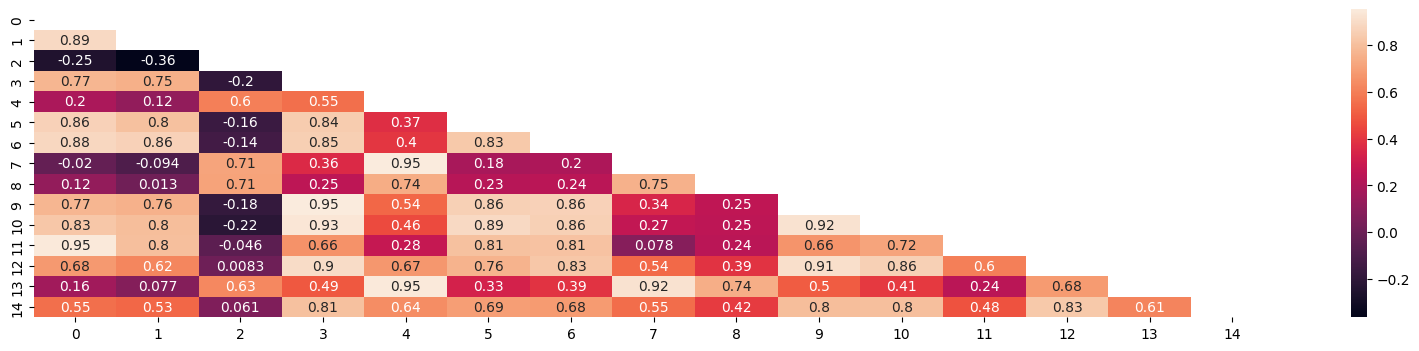

In [224]:
plt.figure(figsize=(20,4))

sns.heatmap(Books_cosine_sim_matrix[:15,:15],annot=True,mask=np.triu(Books_cosine_sim_matrix[:15,:15]))

plt.show()

#### Test CBF by original_title of Book using fuzzy matching to find the best title match.

In [225]:
def get_recommendations_CBF(title:str, cosine_sim_matrix=Books_cosine_sim_matrix, df=df_books):

    title = title.strip()
  
    all_titles = df['original_title'].fillna('').astype(str).tolist()

    best_match = process.extractOne(title,all_titles,scorer=fuzz.partial_ratio, score_cutoff=75 )

    if best_match is None:
        return "No recommendations found. Please try a different title."

    matched_title, match_score, matched_index = best_match

    print(f"Best matched Book found: '{matched_title}' With Match Score: {match_score}% And Its index in df_books is {matched_index}")

    sim_scores = list(enumerate(cosine_sim_matrix[matched_index]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:4]

    book_indices = []
    for i in sim_scores:
            book_indices.append(i[0])


    result = df[['original_title','authors','original_publication_year','average_rating']].iloc[book_indices].reset_index(drop=True)

    return result

In [226]:
get_recommendations_CBF('Harry Potter and the Deathly Hallows')

Best matched Book found: 'Harry Potter and the Deathly Hallows' With Match Score: 100.0% And Its index in df_books is 24


,original_title,authors,original_publication_year,average_rating
0,Harry Potter and the Half-Blood Prince,"J.K. Rowling, Mary GrandPré",2005.0,4.54
1,Harry Potter and the Goblet of Fire,"J.K. Rowling, Mary GrandPré",2000.0,4.53
2,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,2005.0,4.73


- **Collaborative Filtering (CF)** → Recommends books based on user–item interactions (ratings). 

In [227]:
df_ratings_copied = df_rating[['user_id', 'book_id', 'rating']].copy()

In [228]:
CF_ratings = df_ratings_copied.groupby(['user_id', 'book_id'], as_index=False).mean()

In [229]:
CF_ratings.sample(10)

,user_id,book_id,rating
3698483,32341,2356,5.0
2445612,21152,28,3.0
3078405,26731,24,5.0
5306906,47170,9,4.0
2430429,21019,546,4.0
1327479,11356,198,5.0
5943277,53116,3106,3.0
1878733,16178,180,5.0
3953294,34666,5717,5.0
2469030,21358,138,2.0


In [230]:
rating_rows = CF_ratings['user_id'] - 1    
rating_cols = CF_ratings['book_id'] - 1   
CF_rating_values = CF_ratings['rating']

In [231]:
R = coo_matrix((CF_rating_values, (rating_rows, rating_cols)), shape=(rating_rows.max()+1, rating_cols.max()+1)).tocsr()

print("N of Users ", R.shape[0])   
print("N of Books:", R.shape[1])       
print("N of Ratings :", R.nnz)        

N of Users  53424
N of Books: 10000
N of Ratings : 5976479


In [232]:
n_components = 125

Rsvd = TruncatedSVD(n_components=n_components, random_state=42)

R_SVD = Rsvd.fit_transform(R)
Books_R_SVD = Rsvd.components_.T 

In [233]:
Books_R_SVD.shape

(10000, 125)

In [234]:
Books_cf_cosine_sim = cosine_similarity(Books_R_SVD, Books_R_SVD)

print(Books_cf_cosine_sim.shape) 

(10000, 10000)


#### Test CF by original_title of Book using fuzzy matching to find the best title match.

In [235]:
def get_recommendations_CF(title:str, cosine_sim_matrix=Books_cf_cosine_sim, df=df_books):

    title = title.strip()
  
    all_titles = df['original_title'].fillna('').astype(str).tolist()

    best_match = process.extractOne(title,all_titles,scorer=fuzz.partial_ratio, score_cutoff=75 )

    if best_match is None:
        return "No recommendations found. Please try a different title."

    matched_title, match_score, matched_index = best_match

    print(f"Best matched Book found: '{matched_title}' With Match Score: {match_score}% And Its index in df_books is {matched_index}")

    sim_scores = list(enumerate(cosine_sim_matrix[matched_index]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:4]

    book_indices = []
    for i in sim_scores:
            book_indices.append(i[0])


    result = df[['original_title','authors','original_publication_year','average_rating']].iloc[book_indices].reset_index(drop=True)

    return result

In [236]:
get_recommendations_CF('The Valley of Horses')

Best matched Book found: 'The Valley of Horses' With Match Score: 100.0% And Its index in df_books is 2046


,original_title,authors,original_publication_year,average_rating
0,The Mammoth Hunters,Jean M. Auel,1985.0,3.88
1,The Plains of Passage,Jean M. Auel,1990.0,3.77
2,The Shelters of Stone,Jean M. Auel,2002.0,3.80


In [237]:
def get_hybrid_recommendations(book_title:str, n_recommendations=5, cbf_matrix=Books_cosine_sim_matrix, cf_matrix=Books_cf_cosine_sim, dfBooks=df_books, weight=0.7):
    """
    Return 5 Recommended Books Based on Book Title\n
    Usage:
    \tEnter original title of the Book\n\n\tTry df_books['original_title'].sample() for an idea\n\n\tif Book not found Enter Author name
    """
    book_title=book_title.strip()
    book_titles = dfBooks['original_title'].tolist()
    author_titles = dfBooks['authors'].tolist()
    

    result = process.extractOne(book_title, book_titles, scorer=fuzz.WRatio)
    
    if result is None or result[1] < 70:  # Threshold: only accept >70% similarity
        print(f"Book '{book_title}' not found in the dataset.\n")
        # return None
       
        second_layer_title=input("\nEnter Author name or tags to investigate\n")
        second_layer_title=second_layer_title.strip()

        secondresult = process.extractOne(second_layer_title, author_titles, scorer=fuzz.WRatio)
       
        if secondresult is None or secondresult[1] < 70: 
             print(f"Author '{book_title}' not found in the dataset.\n")
             return None
        second_matched_title, second_score, second_matched_idx = secondresult  
        print(f"Found matching Author: '{second_matched_title}' (similarity: {second_score:.1f}%), (Index in df_books {second_matched_idx+1})\n\n")
        
        auhthor_idx = second_matched_idx 

        second_hybrid_sim_matrix = (weight * cbf_matrix) + ((1 - weight) * cf_matrix)

        second_sim_scores = list(enumerate(second_hybrid_sim_matrix[auhthor_idx]))
        second_sim_scores = sorted(second_sim_scores, key=lambda x: x[1], reverse=True)

        second_sim_scores = second_sim_scores[1:n_recommendations+1]
        authors_indices = [i[0] for i in second_sim_scores]

        display( dfBooks.iloc[authors_indices][[ 'original_title', 'authors','original_publication_year','average_rating']].reset_index(drop=True))
        # return display( dfBooks.iloc[authors_indices][[[ 'original_title', 'authors','original_publication_year','average_rating']].reset_index(drop=True))
        return " "

    matched_title, score, matched_idx = result  
    
    print(f"Found matching book: '{matched_title}' (similarity: {score:.1f}%), (Index in df_books {matched_idx+1})")
  
    book_idx = matched_idx 

    hybrid_sim_matrix = (weight * cbf_matrix) + ((1 - weight) * cf_matrix)

    sim_scores = list(enumerate(hybrid_sim_matrix[book_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[:n_recommendations+1]
    book_indices = [i[0] for i in sim_scores]

    display( dfBooks.iloc[book_indices][[ 'original_title', 'authors','original_publication_year','average_rating']].reset_index(drop=True))
    return " "

In [239]:
get_hybrid_recommendations("Ancient Egypt")

Found matching book: 'Warlock: A Novel of Ancient Egypt' (similarity: 90.0%), (Index in df_books 8806)


,original_title,authors,original_publication_year,average_rating
0,Warlock: A Novel of Ancient Egypt,Wilbur Smith,1995.0,4.02
1,The Seventh Scroll,Wilbur Smith,1995.0,4.10
2,River God,Wilbur Smith,1993.0,4.20
3,When the Lion Feeds,Wilbur Smith,1964.0,4.16
4,The Valley of Horses,Jean M. Auel,1982.0,3.98
5,The First Man in Rome,Colleen McCullough,1990.0,4.08


' '

In [240]:
def image_viewer(booktitle:str):

    image_getter=df_books[df_books['original_title']==booktitle]['image_url'].to_list()[0]
   
    return image_getter

In [241]:
def Top_Books_Rated_year(Book_Publication_year:int):

    return df_books[df_books['original_publication_year']==Book_Publication_year].sort_values(by='average_rating',ascending=False).head()[['original_title','authors','average_rating']].reset_index(drop=True)

In [242]:
def Book_tags_getter(booktitle:str,Noftags=5):

    goodreads_book_id_getter=df_books[df_books['original_title']==booktitle]['goodreads_book_id'].to_list()[0]
    Booktags=pd.merge(df_booktags[df_booktags['goodreads_book_id']==goodreads_book_id_getter]['tag_id'],df_tags,how='inner',on='tag_id')['tag_name'][2:Noftags].tolist()

    return Booktags

In [243]:
import joblib

joblib.dump(df_books, 'df_books.joblib')
joblib.dump(df_booktags, 'df_booktags.joblib')
joblib.dump(df_tags, 'df_tags.joblib')
joblib.dump(Books_cosine_sim_matrix, 'cbf_matrix.joblib')
joblib.dump(Books_cf_cosine_sim, 'cf_matrix.joblib')

print("Objects saved successfully using Joblib.")

Objects saved successfully using Joblib.
